<a href="https://colab.research.google.com/github/MHMotamedi97/Parallel-Computing/blob/main/MPI_Benchmarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%writefile parallel_messaging.cpp
#include <mpi.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h>

int main(int argc, char *argv[]) {

    MPI_Init(&argc, &argv);

    int my_rank, comm_size;
    MPI_Comm_rank(MPI_COMM_WORLD, &my_rank);
    MPI_Comm_size(MPI_COMM_WORLD, &comm_size);

    if (comm_size != 2) {
        if (my_rank == 0)
            printf("This program must be run with exactly 2 MPI processes.\n");
        MPI_Finalize();
        return 0;
    }

    /* Read MESSAGE_COUNT from command-line arguments */
    if (argc < 2) {
        if (my_rank == 0)
            printf("Usage: mpirun -n 2 ./parallel_messaging <MESSAGE_COUNT>\n");
        MPI_Finalize();
        return 0;
    }

    const int MESSAGE_COUNT = atoi(argv[1]);
    if (MESSAGE_COUNT <= 0) {
        if (my_rank == 0)
            printf("MESSAGE_COUNT must be a positive integer.\n");
        MPI_Finalize();
        return 0;
    }

    /* Rank 0 opens output file */
    FILE *outfile = NULL;
    if (my_rank == 0) {
        outfile = fopen("latency_results.txt", "w");
        if (!outfile) {
            printf("Error: Unable to open output file.\n");
            MPI_Finalize();
            return 0;
        }
        fprintf(outfile, "MESSAGE_COUNT = %d\n\n", MESSAGE_COUNT);
        fprintf(outfile, "MessageSize(bytes), AvgLatency(seconds)\n");
    }

    /* Test message sizes (bytes) */
    int message_sizes[] = {1, 256, 512, 1024, 2048, 4096, 8192, 16384};
    int num_sizes = sizeof(message_sizes) / sizeof(message_sizes[0]);

    for (int ms = 0; ms < num_sizes; ms++) {

        int size = message_sizes[ms];
        char *buffer = (char *) malloc(size);

        memset(buffer, 0, size);

        MPI_Barrier(MPI_COMM_WORLD);

        if (my_rank == 0) {

            double start = MPI_Wtime();

            for (int i = 0; i < MESSAGE_COUNT; i++) {
                MPI_Send(buffer, size, MPI_BYTE, 1, 0, MPI_COMM_WORLD);
                MPI_Recv(buffer, size, MPI_BYTE, 1, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
            }

            double end = MPI_Wtime();
            double elapsed = end - start;

            double avg_one_way_latency = elapsed / (2.0 * MESSAGE_COUNT);

            printf("Message Size: %d bytes, Avg Latency: %e seconds\n",
                   size, avg_one_way_latency);

            /* Write result to file */
            fprintf(outfile, "%d, %e\n", size, avg_one_way_latency);

        } else {

            for (int i = 0; i < MESSAGE_COUNT; i++) {
                MPI_Recv(buffer, size, MPI_BYTE, 0, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
                MPI_Send(buffer, size, MPI_BYTE, 0, 0, MPI_COMM_WORLD);
            }
        }

        free(buffer);
    }

    if (my_rank == 0) {
        fclose(outfile);
    }

    MPI_Finalize();
    return 0;
}


Writing parallel_messaging.cpp


In [ ]:
%%bash
mpicxx parallel_messaging.cpp -o parallel_messaging.exe -lm

In [ ]:
%%bash
mpirun --allow-run-as-root --oversubscribe -np 2 ./parallel_messaging.exe 1000

Message Size: 1 bytes, Avg Latency: 5.497095e-07 seconds
Message Size: 256 bytes, Avg Latency: 6.200640e-07 seconds
Message Size: 512 bytes, Avg Latency: 8.138740e-07 seconds
Message Size: 1024 bytes, Avg Latency: 7.999310e-07 seconds
Message Size: 2048 bytes, Avg Latency: 8.898600e-07 seconds
Message Size: 4096 bytes, Avg Latency: 2.951729e-06 seconds
Message Size: 8192 bytes, Avg Latency: 3.574786e-06 seconds
Message Size: 16384 bytes, Avg Latency: 4.232032e-06 seconds


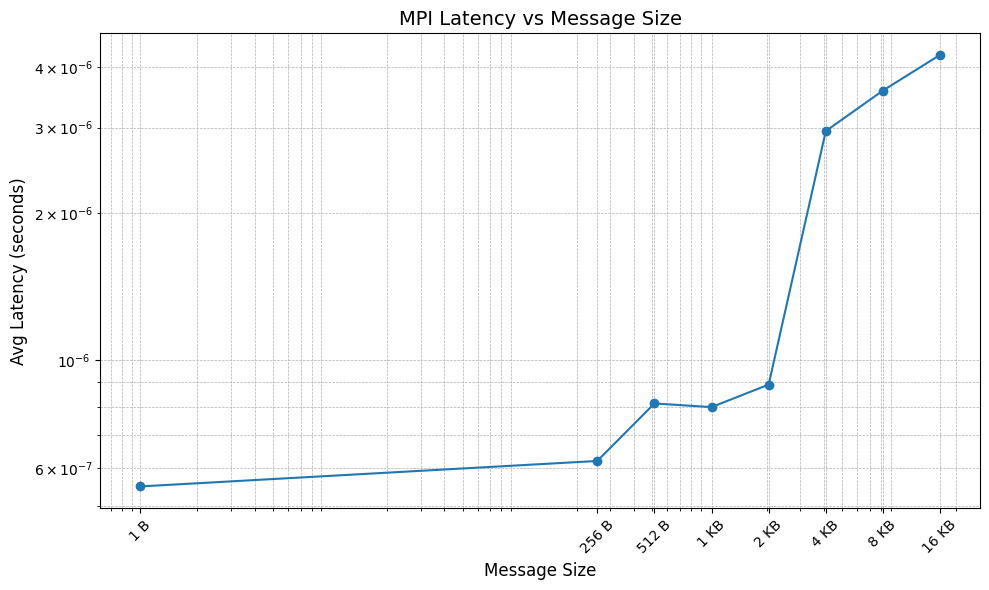

In [ ]:
import matplotlib.pyplot as plt
import os

filename = "latency_results.txt"

def format_bytes(x):
    if x < 1024:
        return f"{x} B"
    else:
        return f"{x//1024} KB"

if not os.path.exists(filename):
    print("Error: latency_results.txt not found. Run the MPI program first.")
else:
    sizes = []
    latencies = []

    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("MESSAGE_COUNT") or "MessageSize" in line:
                continue

            parts = line.split(",")
            if len(parts) == 2:
                try:
                    sizes.append(int(parts[0]))
                    latencies.append(float(parts[1]))
                except ValueError:
                    pass

    if len(sizes) == 0:
        print("No valid data found.")
    else:
        plt.figure(figsize=(10,6))

        plt.plot(sizes, latencies, marker='o')

        # Log scale
        plt.xscale("log")
        plt.yscale("log")

        plt.xticks(sizes, [format_bytes(s) for s in sizes], rotation=45)

        plt.xlabel("Message Size", fontsize=12)
        plt.ylabel("Avg Latency (seconds)", fontsize=12)
        plt.title("MPI Latency vs Message Size", fontsize=14)
        plt.grid(True, which="both", linestyle="--", linewidth=0.5)

        plt.tight_layout()
        plt.show()


# Ring messaging

In [ ]:
%%writefile ring_messaging.cpp
#include <mpi.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h>

int main(int argc, char *argv[]) {

    MPI_Init(&argc, &argv);

    int my_rank, comm_size;
    MPI_Comm_rank(MPI_COMM_WORLD, &my_rank);
    MPI_Comm_size(MPI_COMM_WORLD, &comm_size);

    /* Read MESSAGE_COUNT from command-line arguments */
    if (argc < 2) {
        if (my_rank == 0)
            printf("Usage: mpirun -n 2 ./parallel_messaging <MESSAGE_COUNT>\n");
        MPI_Finalize();
        return 0;
    }

    const int MESSAGE_COUNT = atoi(argv[1]);
    if (MESSAGE_COUNT <= 0) {
        if (my_rank == 0)
            printf("MESSAGE_COUNT must be a positive integer.\n");
        MPI_Finalize();
        return 0;
    }

    /* Rank 0 opens output file */
    FILE *outfile = NULL;
    if (my_rank == 0) {
        outfile = fopen("ring_latency_results.txt", "w");
        if (!outfile) {
            printf("Error: Unable to open output file.\n");
            MPI_Finalize();
            return 0;
        }
        fprintf(outfile, "MESSAGE_COUNT = %d\n\n", MESSAGE_COUNT);
        fprintf(outfile, "MessageSize(bytes), AvgLatency(seconds)\n");
    }

    /* Test message sizes (bytes) */
    int message_sizes[] = {1, 256, 512, 1024, 2048, 4096, 8192, 16384};
    int num_sizes = sizeof(message_sizes) / sizeof(message_sizes[0]);

    for (int ms = 0; ms < num_sizes; ms++) {

        int size = message_sizes[ms];
        char *buffer = (char *) malloc(size);

        memset(buffer, 0, size);

        MPI_Barrier(MPI_COMM_WORLD);

        if (my_rank == 0) {
            int next = 1 % comm_size;
            int prev = (comm_size - 1);

            double start = MPI_Wtime();

            for (int i = 0; i < MESSAGE_COUNT; i++) {
                MPI_Send(buffer, size, MPI_BYTE, next, 0, MPI_COMM_WORLD);
                MPI_Recv(buffer, size, MPI_BYTE, prev, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
            }

            double end = MPI_Wtime();
            double elapsed = end - start;

            double avg_one_way_latency = elapsed / (2.0 * MESSAGE_COUNT);

            printf("Message Size: %d bytes, Avg Latency: %e seconds\n",
                   size, avg_one_way_latency);

            /* Write result to file */
            fprintf(outfile, "%d, %e\n", size, avg_one_way_latency);

        } else {
            int next = (my_rank + 1) % comm_size;
            int prev = (my_rank - 1 + comm_size) % comm_size;

            for (int i = 0; i < MESSAGE_COUNT; i++) {
                MPI_Recv(buffer, size, MPI_BYTE, prev, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
                MPI_Send(buffer, size, MPI_BYTE, next, 0, MPI_COMM_WORLD);
            }
        }

        free(buffer);
    }

    if (my_rank == 0) {
        fclose(outfile);
    }

    MPI_Finalize();
    return 0;
}


Overwriting ring_messaging.cpp


In [ ]:

%%bash
mpicxx ring_messaging.cpp -o ring_messaging.exe -lm


In [ ]:
%%bash
for i in {1..1000}; do
    ts=$(date +"%Y%m%d_%H%M%S_%3N")
    mpirun --allow-run-as-root --oversubscribe -np 2 ./ring_messaging.exe 1000 \
        > results_run_2_$ts.txt
    sleep 0.1
done


Found 1100 result files.
Size 1 bytes: mean latency = 1.0075368881818182e-06 s over 1100 runs
Size 256 bytes: mean latency = 9.790236786363636e-07 s over 1100 runs
Size 512 bytes: mean latency = 1.1570845927272728e-06 s over 1100 runs
Size 1024 bytes: mean latency = 1.181720835909091e-06 s over 1100 runs
Size 2048 bytes: mean latency = 1.271117506363636e-06 s over 1100 runs
Size 4096 bytes: mean latency = 3.6416962181818176e-06 s over 1100 runs
Size 8192 bytes: mean latency = 4.1295572890909084e-06 s over 1100 runs
Size 16384 bytes: mean latency = 5.168512329090909e-06 s over 1100 runs


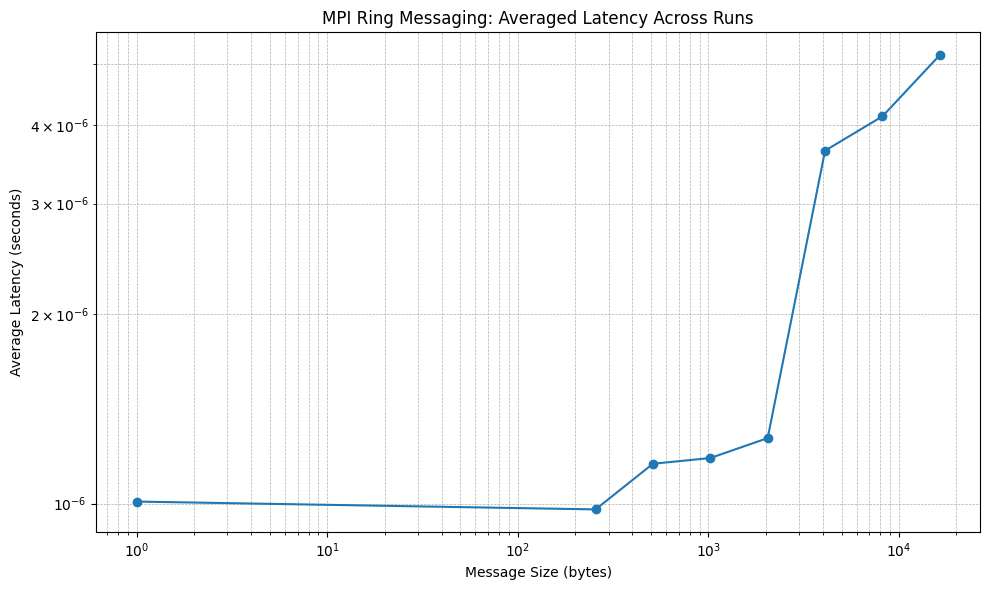

In [ ]:
import re
import glob
import numpy as np
import matplotlib.pyplot as plt

# Pattern to match lines like:
# Message Size: 1024 bytes, Avg Latency: 1.73e-05 seconds
pattern = re.compile(
    r"Message Size:\s*(\d+)\s*bytes,\s*Avg Latency:\s*([0-9.eE+-]+)\s*seconds"
)

# Dictionary to accumulate data
# msg_size → list of latencies
data = {}

# Read all files matching pattern
files = glob.glob("results_run_2_*.txt")
if not files:
    raise RuntimeError("No results_run_*.txt files found!")

print(f"Found {len(files)} result files.")

for fname in files:
    with open(fname, "r") as f:
        for line in f:
            m = pattern.search(line)
            if m:
                size = int(m.group(1))
                latency = float(m.group(2))
                data.setdefault(size, []).append(latency)

# Compute averages
avg_sizes = []
avg_latencies = []

for size in sorted(data.keys()):
    lat_list = data[size]
    avg = np.mean(lat_list)
    avg_sizes.append(size)
    avg_latencies.append(avg)
    print(f"Size {size} bytes: mean latency = {avg} s over {len(lat_list)} runs")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(avg_sizes, avg_latencies, marker='o')

plt.xscale("log")  # Message sizes differ exponentially
plt.yscale("log")  # Latency often benefits from log view

plt.xlabel("Message Size (bytes)")
plt.ylabel("Average Latency (seconds)")
plt.title("MPI Ring Messaging: Averaged Latency Across Runs")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()


In [ ]:
%%bash
for i in {1..1000}; do
    ts=$(date +"%Y%m%d_%H%M%S_%3N")
    mpirun --allow-run-as-root --oversubscribe -np 4 ./ring_messaging.exe 1000 \
        > results_run_4_$ts.txt
    sleep 0.1
done


Found 1100 result files.
Size 1 bytes: mean latency = 5.468904886363637e-06 s over 1100 runs
Size 256 bytes: mean latency = 5.4098216336363634e-06 s over 1100 runs
Size 512 bytes: mean latency = 6.362890660909091e-06 s over 1100 runs
Size 1024 bytes: mean latency = 6.568419466363636e-06 s over 1100 runs
Size 2048 bytes: mean latency = 6.7759994672727275e-06 s over 1100 runs
Size 4096 bytes: mean latency = 1.3653068421818182e-05 s over 1100 runs
Size 8192 bytes: mean latency = 1.454459975e-05 s over 1100 runs
Size 16384 bytes: mean latency = 1.6293065145454543e-05 s over 1100 runs


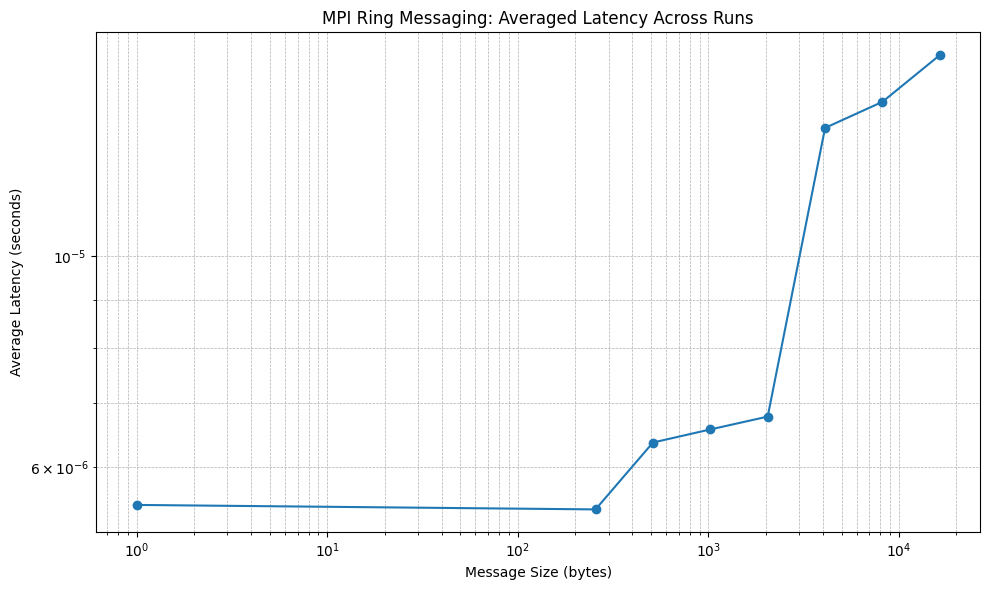

In [ ]:
import re
import glob
import numpy as np
import matplotlib.pyplot as plt

# Pattern to match lines like:
# Message Size: 1024 bytes, Avg Latency: 1.73e-05 seconds
pattern = re.compile(
    r"Message Size:\s*(\d+)\s*bytes,\s*Avg Latency:\s*([0-9.eE+-]+)\s*seconds"
)

# Dictionary to accumulate data
# msg_size → list of latencies
data = {}

# Read all files matching pattern
files = glob.glob("results_run_4_*.txt")
if not files:
    raise RuntimeError("No results_run_*.txt files found!")

print(f"Found {len(files)} result files.")

for fname in files:
    with open(fname, "r") as f:
        for line in f:
            m = pattern.search(line)
            if m:
                size = int(m.group(1))
                latency = float(m.group(2))
                data.setdefault(size, []).append(latency)

# Compute averages
avg_sizes = []
avg_latencies = []

for size in sorted(data.keys()):
    lat_list = data[size]
    avg = np.mean(lat_list)
    avg_sizes.append(size)
    avg_latencies.append(avg)
    print(f"Size {size} bytes: mean latency = {avg} s over {len(lat_list)} runs")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(avg_sizes, avg_latencies, marker='o')

plt.xscale("log")  # Message sizes differ exponentially
plt.yscale("log")  # Latency often benefits from log view

plt.xlabel("Message Size (bytes)")
plt.ylabel("Average Latency (seconds)")
plt.title("MPI Ring Messaging: Averaged Latency Across Runs")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()


In [ ]:
%%bash
for i in {1..1000}; do
    ts=$(date +"%Y%m%d_%H%M%S_%3N")
    mpirun --allow-run-as-root --oversubscribe -np 8 ./ring_messaging.exe 1000 \
        > results_run_8_$ts.txt
    sleep 0.1
done


Found 1100 result files.
Size 1 bytes: mean latency = 3.105994193636363e-05 s over 1100 runs
Size 256 bytes: mean latency = 3.08012228e-05 s over 1100 runs
Size 512 bytes: mean latency = 3.1991689154545455e-05 s over 1100 runs
Size 1024 bytes: mean latency = 3.077328132727273e-05 s over 1100 runs
Size 2048 bytes: mean latency = 3.0501430999999997e-05 s over 1100 runs
Size 4096 bytes: mean latency = 4.570294065454545e-05 s over 1100 runs
Size 8192 bytes: mean latency = 4.7879038263636366e-05 s over 1100 runs
Size 16384 bytes: mean latency = 5.4145836581818174e-05 s over 1100 runs


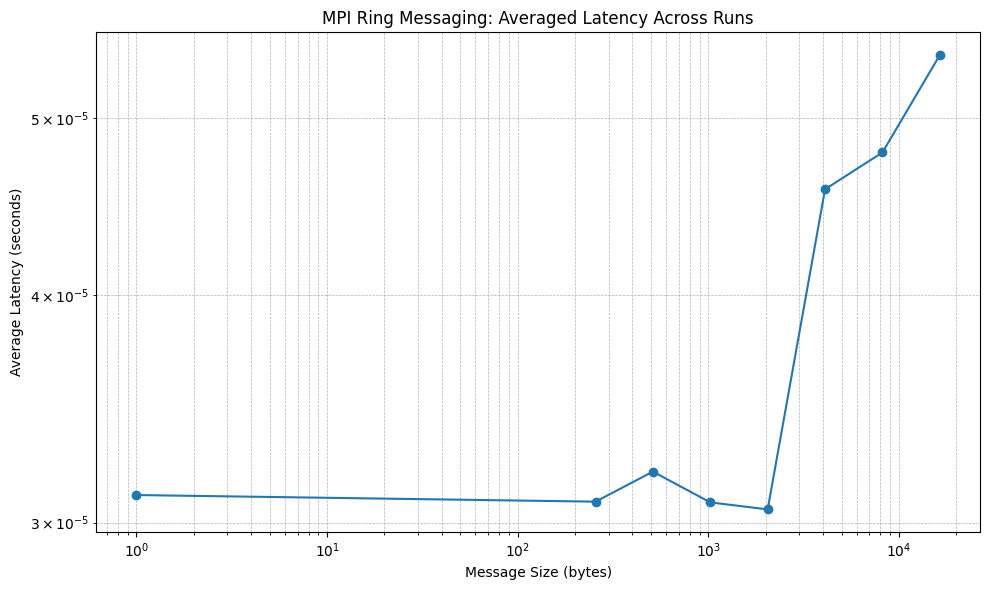

In [ ]:
import re
import glob
import numpy as np
import matplotlib.pyplot as plt

# Pattern to match lines like:
# Message Size: 1024 bytes, Avg Latency: 1.73e-05 seconds
pattern = re.compile(
    r"Message Size:\s*(\d+)\s*bytes,\s*Avg Latency:\s*([0-9.eE+-]+)\s*seconds"
)

# Dictionary to accumulate data
# msg_size → list of latencies
data = {}

# Read all files matching pattern
files = glob.glob("results_run_8_*.txt")
if not files:
    raise RuntimeError("No results_run_*.txt files found!")

print(f"Found {len(files)} result files.")

for fname in files:
    with open(fname, "r") as f:
        for line in f:
            m = pattern.search(line)
            if m:
                size = int(m.group(1))
                latency = float(m.group(2))
                data.setdefault(size, []).append(latency)

# Compute averages
avg_sizes = []
avg_latencies = []

for size in sorted(data.keys()):
    lat_list = data[size]
    avg = np.mean(lat_list)
    avg_sizes.append(size)
    avg_latencies.append(avg)
    print(f"Size {size} bytes: mean latency = {avg} s over {len(lat_list)} runs")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(avg_sizes, avg_latencies, marker='o')

plt.xscale("log")  # Message sizes differ exponentially
plt.yscale("log")  # Latency often benefits from log view

plt.xlabel("Message Size (bytes)")
plt.ylabel("Average Latency (seconds)")
plt.title("MPI Ring Messaging: Averaged Latency Across Runs")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()


In [ ]:
%%bash
for i in {1..1000}; do
    ts=$(date +"%Y%m%d_%H%M%S_%3N")
    mpirun --allow-run-as-root --oversubscribe -np 16 ./ring_messaging.exe 1000 \
        > results_run_16_$ts.txt
    sleep 0.1
done


Found 1100 result files.
Size 1 bytes: mean latency = 0.00014703032557272729 s over 1100 runs
Size 256 bytes: mean latency = 0.0001489245455090909 s over 1100 runs
Size 512 bytes: mean latency = 0.0001493695794818182 s over 1100 runs
Size 1024 bytes: mean latency = 0.00014807229696363637 s over 1100 runs
Size 2048 bytes: mean latency = 0.00014909239831818182 s over 1100 runs
Size 4096 bytes: mean latency = 0.00018101203756363635 s over 1100 runs
Size 8192 bytes: mean latency = 0.00018371412188181817 s over 1100 runs
Size 16384 bytes: mean latency = 0.00019905079163636365 s over 1100 runs


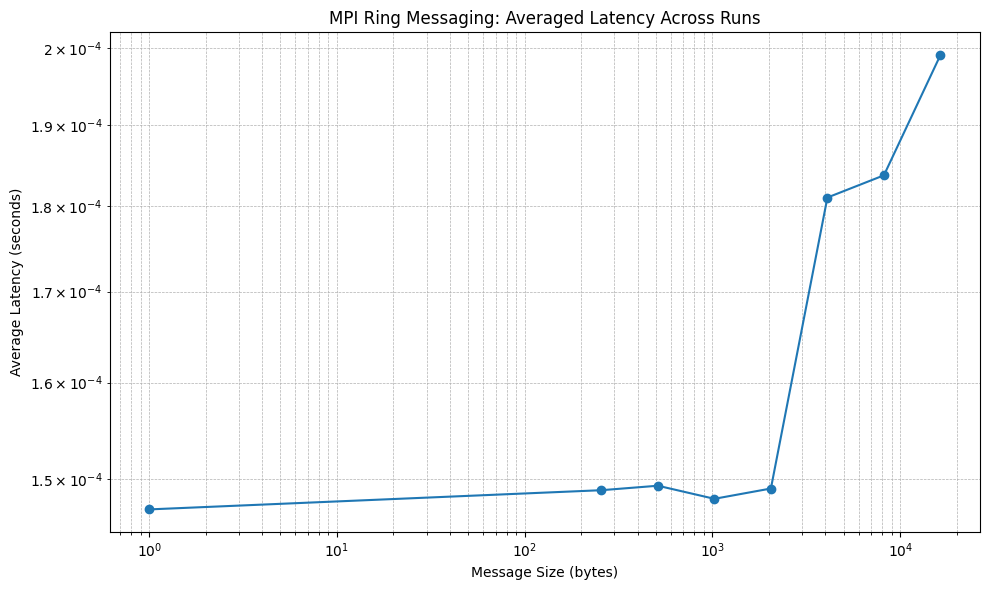

In [ ]:
import re
import glob
import numpy as np
import matplotlib.pyplot as plt

# Pattern to match lines like:
# Message Size: 1024 bytes, Avg Latency: 1.73e-05 seconds
pattern = re.compile(
    r"Message Size:\s*(\d+)\s*bytes,\s*Avg Latency:\s*([0-9.eE+-]+)\s*seconds"
)

# Dictionary to accumulate data
# msg_size → list of latencies
data = {}

# Read all files matching pattern
files = glob.glob("results_run_16_*.txt")
if not files:
    raise RuntimeError("No results_run_*.txt files found!")

print(f"Found {len(files)} result files.")

for fname in files:
    with open(fname, "r") as f:
        for line in f:
            m = pattern.search(line)
            if m:
                size = int(m.group(1))
                latency = float(m.group(2))
                data.setdefault(size, []).append(latency)

# Compute averages
avg_sizes = []
avg_latencies = []

for size in sorted(data.keys()):
    lat_list = data[size]
    avg = np.mean(lat_list)
    avg_sizes.append(size)
    avg_latencies.append(avg)
    print(f"Size {size} bytes: mean latency = {avg} s over {len(lat_list)} runs")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(avg_sizes, avg_latencies, marker='o')

plt.xscale("log")  # Message sizes differ exponentially
plt.yscale("log")  # Latency often benefits from log view

plt.xlabel("Message Size (bytes)")
plt.ylabel("Average Latency (seconds)")
plt.title("MPI Ring Messaging: Averaged Latency Across Runs")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()
